In [ ]:
"""
    -- Description:
        
        (1) Conduct Convex Optimization for portfolio optimization (target: maximize Sharpe Ratio)
        
        (2) Draw the efficient frontier for the portfolio (target: given return, minimize volatility)
        
    -- Prerequisite:
        
        Quandl API Key
        
    -- Auther:
        
        Fang Fan (Roy)
        
    -- Date:
        
        August 23, 2020
    
"""

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import quandl

%matplotlib inline
quandl.ApiConfig.api_key = "okePP6eysAeuyx8BnX7k"
sns.set()

## Load Historical Equities Data

In [2]:
def load_historical_equity_data(ticker, start, end):
    try:
        return quandl.get("WIKI/{}.11".format(ticker), start_date=start, end_date=end)["Adj. Close"]
    except:
        print("Data loading for '{}' failed.".format(ticker))
        return None
        

In [3]:
tickers = ["AAPL", "AXP", "BA", "CAT", "CSCO", "CVX", "DIS"]

start = pd.to_datetime("2012-01-01")
end = pd.to_datetime("2018-01-01")

df_equity = pd.DataFrame()
for ticker in tickers:
    df_equity[ticker] = load_historical_equity_data(ticker, start, end)

df_equity.head()

,AAPL,AXP,BA,CAT,CSCO,CVX,DIS
Date,,,,,,,
2012-01-03,52.848787,44.396879,63.682364,78.482928,15.617341,88.744198,35.569102
2012-01-04,53.132802,44.424403,63.776746,79.209467,15.919125,88.591427,36.070468
2012-01-05,53.722681,44.940109,63.090329,79.768986,15.860445,87.723041,36.673963
2012-01-06,54.284287,44.452030,63.476439,79.969410,15.801764,87.087833,37.054630
2012-01-09,54.198183,44.562539,63.948350,81.088448,15.902359,88.036625,36.906077


## Log Returns

In [4]:
df_ret = np.log(df_equity / df_equity.shift(1)).dropna()

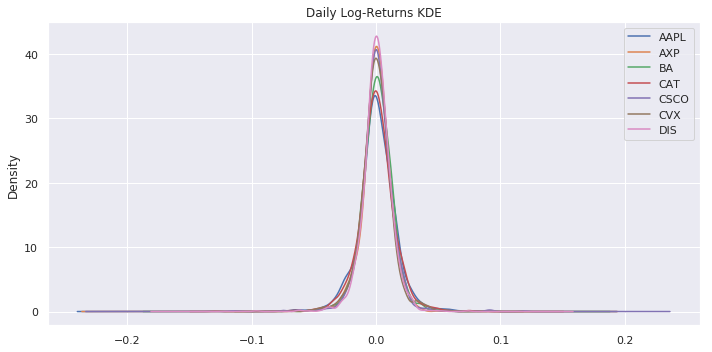

In [5]:
df_ret.plot(kind="kde", figsize=(10, 5))

plt.title("Daily Log-Returns KDE")
plt.tight_layout()

## Portfolio Optimization  |  Target: Maximal Sharpe Ratio

In [6]:
from scipy.optimize import minimize

In [7]:
def get_portfolio_return_volatility_sharpe_ratio(weights):
    '''
    -- Desc
        
        Calculate the annualized log return, volatility and Sharpe Ratio for the portfolio.
        
        We assume that the risk free rate is zero, for simplicity.
        
    -- Return
        
        Tuple of annualized (log return, volatility, sharp ratio)
        
    '''
    weights = np.array(weights)
    log_ret = np.sum(df_ret.mean(axis=0) * weights) * 252
    volatility = np.sqrt(np.dot(weights, np.dot(df_ret.cov(), weights))) * np.sqrt(252)
    sr = log_ret / volatility
    
    return (log_ret, volatility, sr)

In [8]:
def target_func(weights):
    '''
        Optimization target: Find maximal SR, i.e. minimal (-SR)
    '''
    return get_portfolio_return_volatility_sharpe_ratio(weights)[2] * (-1)
    

In [9]:
def check_sum(weights):
    '''
        The weights of instruments in the portfolio should add up to 1
    '''
    return np.sum(weights) - 1

In [10]:
# We won't consider short positions
bounds = tuple((0,1) for _ in tickers)

constraints = ({"type":"eq", "fun": check_sum})
init_guess = [1/len(tickers)] * len(tickers)

## Optimized Portfolio Breakdown

In [11]:
opt_results = minimize(target_func, 
                       init_guess, 
                       method="SLSQP", 
                       bounds=bounds, 
                       constraints=constraints)

In [12]:
print("Optimal Sharpe Ratio for the portfolio is {}\n".format(round(-opt_results["fun"],6)))

for i, ticker in enumerate(tickers):
    print("Weight({}) : {}%".format(ticker, round(opt_results["x"][i]*100, 4)))

Optimal Sharpe Ratio for the portfolio is 1.410939

Weight(AAPL) : 15.3741%
Weight(AXP) : 0.6238%
Weight(BA) : 47.8689%
Weight(CAT) : 0.0%
Weight(CSCO) : 5.6098%
Weight(CVX) : 0.0%
Weight(DIS) : 30.5234%


## Efficient Frontier (given each return, find minimal volatility)

In [13]:
ef_ret = np.linspace(0.075, 0.25, 300)

In [14]:
def target_func_2(weights):
    '''
        The optimization target is to find minimal volatility, given the return
    '''
    return get_portfolio_return_volatility_sharpe_ratio(weights)[1]

In [15]:
ef_vol = []
for ret in ef_ret:
    def check_sum_2(weights):
        return np.sum(df_ret.mean(axis=0)*weights) * 252 - ret
    
    bounds = tuple((0,1) for _ in tickers)
    constraints = ({"type":"eq", "fun":check_sum},
                   {"type":"eq", "fun":check_sum_2})
    init_guess = [1/len(tickers)] * len(tickers)
    
    result = minimize(target_func_2, init_guess, method="SLSQP", bounds=bounds, constraints=constraints)
    ef_vol.append(result["fun"])

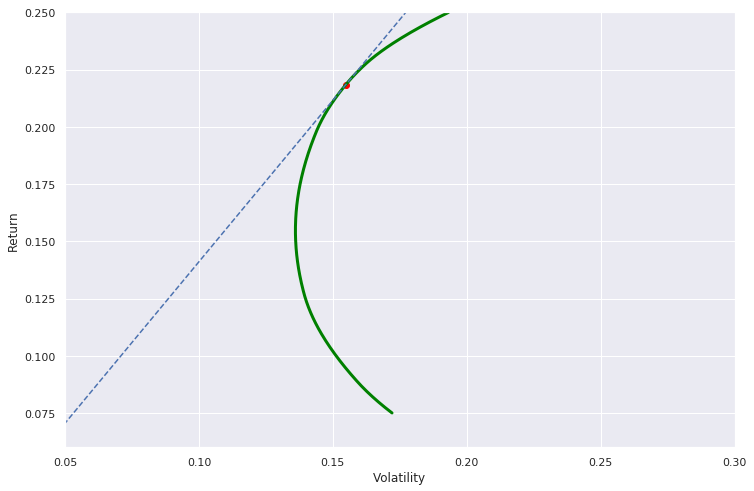

In [16]:
opt_ret, opt_vol, opt_sr = get_portfolio_return_volatility_sharpe_ratio(opt_results["x"])

fig = plt.figure(figsize=(12, 8))
plt.xlim((0.05 ,0.3))
plt.ylim((0.06 ,0.25))

plt.xlabel("Volatility")
plt.ylabel("Return")


plt.plot(ef_vol, ef_ret, ls="-", lw=3, c="green")
ax = plt.gca()
ax.add_line(mlines.Line2D([0,2*opt_vol], [0,2*opt_ret], ls="--"))
plt.scatter(opt_vol, opt_ret, c="red")
